In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from data_assimilation import assimilate

In [48]:
def seir_step(state):
    state = list(np.ravel(state))
    state = list(map(lambda x : max(x, 0), state))
    S_old, E_old, I_old, R_old, D_old, alfa, beta, eps, gamma = state

    N = S_old + E_old + I_old + R_old
    D = D_old + alfa * I_old
    S = S_old - S_old * beta * I_old / N
    E = E_old + S_old * beta * I_old / N - eps * E_old
    I = I_old + eps * E_old - (alfa + gamma) * I_old
    R = R_old + gamma * I_old
    results = [S, E, I, R, D, alfa, beta, eps, gamma]
    return np.array(results).reshape(-1, 1)

In [55]:
mappings = {
    "s": 0,
    "e": 1,
    "i": 2,
    "r": 3,
    "d": 4
}

def seir_obs_operator(state, t):
    return state.reshape((-1, 9))[:, mappings[t.lower()]]

In [11]:
# helper function to load data from file
def load_data(size=100, country='POL'):
    deaths = []
    cumulative = 0
    with open('covid-deaths1.csv') as f:
        for line in f:
            fields = line.split(',')
            if fields[1] == country:
                cumulative += float(fields[3][:-1])
                deaths.append(cumulative)

    return np.array(deaths[-size:]).reshape((-1, 1))

# helper function to generate observations based on evolution function and observation operator
def prepare_obs(state, obs_operator, evolution_function, size=100):
    a = []
    for i in range(size):
        a.append(obs_operator(state))
        state = evolution_function(state)
    return a

## Training data - last 100 days

In [79]:
training_size = 100

In [ ]:
yobs = load_data(size = training_size, country = 'POL')
seird = [36000000, 1000000, 380000, 80000, 9171]
result = assimilate(seird + [0.001, 0.1, 0.1, 0.1], yobs, lambda x: seir_obs_operator(x, "d"), seir_step, verbose=True)

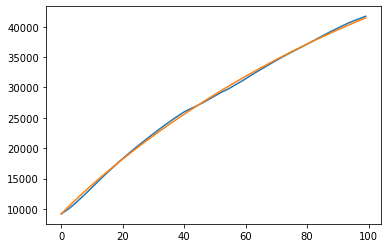

In [15]:
# show fit to training data
res = prepare_obs(result, lambda x: seir_obs_operator(x, "d"), seir_step, training_size)
plt.plot(range(training_size), yobs)
plt.plot(range(training_size), res)

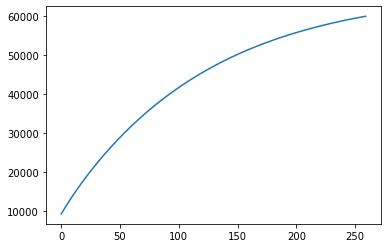

In [32]:
# prediction of total number of deaths 160 days to the future
size = training_size + 160
pred = prepare_obs(result, lambda x: seir_obs_operator(x, "d"), seir_step, size)
plt.plot(range(size), pred)

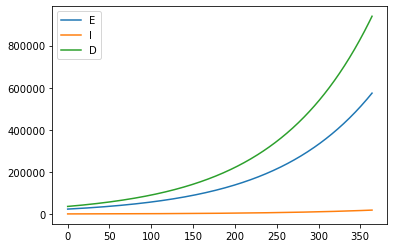

In [80]:
# preditcion of E, I, D 1 year to the future
size = training_size + 365

for t in ["E", "I", "D"]:
    pred = prepare_obs(result, lambda x: seir_obs_operator(x, t), seir_step, size)
    plt.plot(range(365), pred[training_size:], label=t)
plt.legend()

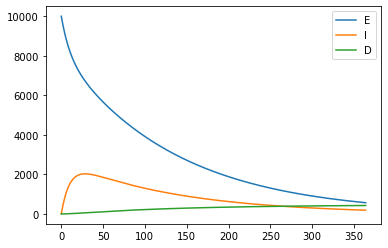

In [61]:
# simulate pandemic from the beginning on fitted parameters
state0 = [37469171, 10000, 0, 0, 0]
state0.extend(result[5:])

size = 365

for t in ["E", "I", "D"]:
    pred = prepare_obs(np.array(state0).reshape(-1, 1), lambda x: seir_obs_operator(x, t), seir_step, size)
    plt.plot(range(size), pred, label=t)
plt.legend()

## Training data - since the beginning

In [73]:
training_size = 346

In [67]:
yobs = load_data(size = training_size, country = 'POL')
seird = [37469171, 1000, 100, 0, 1]
result = assimilate(seird + [0.001, 0.1, 0.1, 0.1], yobs, lambda x: seir_obs_operator(x, "d"), seir_step, verbose=True)

  Intermediate CurrentState at the current iteration: [3.7469171e+07 1.0000000e+03 1.0000000e+02 0.0000000e+00 1.0000000e+00
 1.0000000e-03 1.0000000e-01 1.0000000e-01 1.0000000e-01]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000000e+03  1.00000001e+02 -1.97386469e-10
  1.00000741e+00  9.95124794e-01  1.73961352e-01  1.05051868e-01
  2.11324447e-02]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000001e+03  1.00000009e+02 -1.97426615e-10
  1.00001388e+00  9.93782526e-01  1.84013108e-01  1.04793815e-01
  1.11085236e-02]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000004e+03  1.00000039e+02 -1.97587199e-10
  1.00003974e+00  9.88413454e-01  2.24220133e-01  1.03761604e-01
 -2.89871610e-02]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000020e+03  1.00000200e+02 -2.00794616e-10
  1.00017026e+00  9.61894084e-01  4.47759193e-01  9.78391695e-02
 -1.36789591e-01]
  Interme

  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000031e+03  1.00000304e+02 -1.21884576e-10
  1.00026618e+00  4.19820864e-01  7.02861293e-01  1.41864065e-02
  1.29784422e-02]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000317e+02 -1.26388359e-10
  1.00027677e+00  4.41303902e-01  7.19764961e-01  1.47595316e-02
 -5.62723253e-03]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000317e+02 -1.26226549e-10
  1.00027639e+00  4.40532068e-01  7.19157653e-01  1.47389406e-02
 -4.95877546e-03]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000311e+02 -1.24055563e-10
  1.00027129e+00  4.30176466e-01  7.11009473e-01  1.44626736e-02
  4.00983339e-03]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000316e+02 -1.25982164e-10
  1.00027582e+00  4.39366352e-01  7.18240423e-01  1.47078416e-02
 -3.9491

  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000313e+02 -1.25026213e-10
  1.00027357e+00  4.34806475e-01  7.14652506e-01  1.45861975e-02
 -2.44038729e-08]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000313e+02 -1.25026207e-10
  1.00027357e+00  4.34806447e-01  7.14652483e-01  1.45861968e-02
  3.32544826e-10]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000313e+02 -1.25026207e-10
  1.00027357e+00  4.34806446e-01  7.14652483e-01  1.45861968e-02
  8.79305231e-10]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  1.00000032e+03  1.00000313e+02 -1.25026207e-10
  1.00027357e+00  4.34806447e-01  7.14652483e-01  1.45861968e-02
  3.32544826e-10]
  Intermediate CurrentState at the current iteration: [ 3.74691710e+07  9.99999805e+02  9.99997931e+01  5.45947141e-11
  9.99850990e-01 -4.21962275e-01  4.04317230e-02 -8.25983626e-03
  7.4207

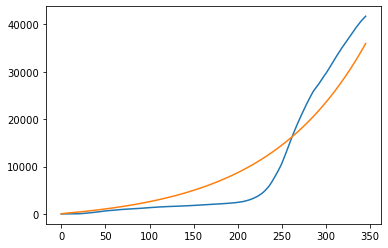

In [74]:
# show fit to training data
res = prepare_obs(result, lambda x: seir_obs_operator(x, "d"), seir_step, training_size)
plt.plot(range(training_size), yobs)
plt.plot(range(training_size), res)

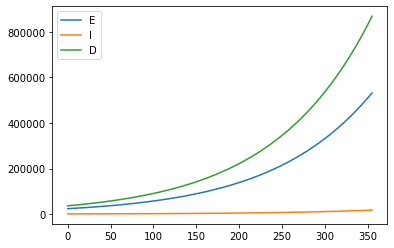

In [76]:
# preditcion of E, I, D 1 year to the future
size = training_size + 356

for t in ["E", "I", "D"]:
    pred = prepare_obs(result, lambda x: seir_obs_operator(x, t), seir_step, size)
    plt.plot(range(356), pred[training_size:], label=t)
plt.legend()

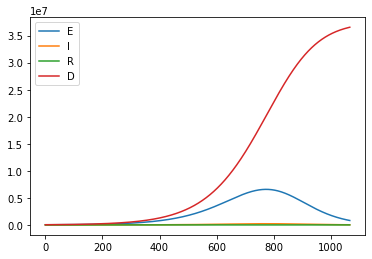

In [78]:
# preditcion of E, I, D 3 years to the future
size = training_size + 3 * 356

for t in ["E", "I", "R", "D"]:
    pred = prepare_obs(result, lambda x: seir_obs_operator(x, t), seir_step, size)
    plt.plot(range(3 * 356), pred[training_size:], label=t)
plt.legend()